# Bayesian Toy Regression for Posterior Learning

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from layers import VBLinear
from activation import switchable_activation
from losses import HetLoss, NaturalHetLoss, MSELoss
from plotting import make_error_fig
from dataset import generate_data

# torch.set_default_dtype(torch.float64)
N_BOUND = -30 if torch.get_default_dtype() == torch.float64 else -20
DTYPE = torch.get_default_dtype()

In [2]:
class BayesNet(nn.Module):

    # default hdn_dim is 30, but can be changed upon initialisation
    def __init__(
        self,
        training_size: int,
        hdn_dims: list[int],
        layers=list[str],
        loss_type: str = "het",
        prior_prec: float = 1.0,
        activation: str = "gelu",
    ):

        super().__init__()

        # the loss function depends on the amount of training data we have, so we need to store this
        self.training_size = training_size
        self.activation = switchable_activation(activation)

        # define loss:
        if loss_type == "het":
            self.loss = HetLoss(lbound=N_BOUND)
        elif loss_type == "natural_het":
            self.loss = NaturalHetLoss(lbound=N_BOUND)
        elif loss_type == "mse":
            self.loss = MSELoss()
        else:
            raise ValueError(
                f"Loss type {loss_type} not recognized. Choose from 'het', 'natural_het', or 'mse'."
            )

        # the activation layers of the network are not bayesian
        # and we need to be able to access the bayesian layers separately
        self.vb_layers = []
        self.all_layers = []

        # define the input layer
        if layers[0] == "vblinear":
            vb_layer = VBLinear(1, hdn_dims[0], prior_prec=prior_prec)
            self.vb_layers.append(vb_layer)
            self.all_layers.append(vb_layer)
            self.all_layers.append(self.activation)
        else:
            linear_layer = nn.Linear(1, hdn_dims[0])
            self.all_layers.append(linear_layer)
            self.all_layers.append(self.activation)

        # loop over hidden layers
        for i, layer in enumerate(layers[1:-1]):
            if layer == "vblinear":
                vb_layer = VBLinear(hdn_dims[i - 1], hdn_dims[i], prior_prec=prior_prec)
                self.vb_layers.append(vb_layer)
                self.all_layers.append(vb_layer)
                self.all_layers.append(self.activation)
            else:
                linear_layer = nn.Linear(hdn_dims[i - 1], hdn_dims[i])
                self.all_layers.append(linear_layer)
                self.all_layers.append(self.activation)

        # define the output layer
        vb_layer = VBLinear(hdn_dims[-1], 2, prior_prec=prior_prec)
        self.vb_layers.append(vb_layer)
        self.all_layers.append(vb_layer)

        # define the model as a Sequential net over all layers
        self.model = nn.Sequential(*self.all_layers)

    def reset_random(self):
        """
        Reset the random state of all bayesian layers.
        """
        for vb_layer in self.vb_layers:
            vb_layer.reset_random()

    # and of course the forward function
    def forward(self, x):
        out = self.model(x)
        return out

    # we need the KL from the bayesian layers to compute the loss function
    def KL(self):
        kl = 0
        for vb_layer in self.vb_layers:
            kl += vb_layer.kl_loss()
        return kl / self.training_size

    # let's put the neg_log_gauss in the network class as it is key to bayesian networks
    def neg_log_gauss(self, outputs: torch.Tensor, targets: torch.Tensor):
        loss, _, _ = self.loss(outputs, targets)
        return torch.mean(loss)

In [3]:
# define training setup
epochs = 1000
batch_size = 200
n_samples = batch_size * 10
unc = 0.1
prior = 1.0
seed = 42

# get reproducible datapoints
x_train, y_train = generate_data(n_samples, unc=unc, seed=seed)

# Fit scaler and save the mean and std to undo
# scaling later
Y_STD = y_train.std()
Y_MEAN = y_train.mean()
y_train_scaled = (y_train - Y_MEAN) / Y_STD

# Define the model and look at it
trn_len = x_train.shape[0]
hdn_dims = [32] * 5
layers = ["linear", "linear", "linear", "linear", "vblinear"]
toy_model = BayesNet(trn_len, hdn_dims=hdn_dims, layers=layers, prior_prec=prior)


# Build dataset
dataset = torch.utils.data.TensorDataset(
    torch.tensor(x_train[:, None], dtype=DTYPE),
    torch.tensor(y_train_scaled, dtype=DTYPE),
)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

opt = torch.optim.AdamW(toy_model.parameters(), lr=5e-3)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, epochs * len(loader))

In [4]:
# Train the model
toy_model.train()

for i in range(epochs):
    train_losses = np.array([])
    kl_losses = np.array([])
    for xb, yb in loader:

        # pass data through network
        pred = toy_model(xb)

        # compute loss
        nl = toy_model.neg_log_gauss(pred, yb)
        kl = toy_model.KL()
        loss = nl + kl

        train_losses = np.append(train_losses, loss.item())
        kl_losses = np.append(kl_losses, kl.item())

        # reset gradients in optimizer
        opt.zero_grad()

        # compute gradients
        loss.backward()

        # update weights with optimizer
        opt.step()
        sched.step()

    train_losses_epoch = train_losses.mean()
    kl_losses_epoch = kl_losses.mean()

    if i % 100 == 0:
        print(f"epoch={i}, loss={train_losses_epoch:.4f}, kl={kl_losses_epoch:.4f}")

epoch=0, loss=0.5157, kl=0.1281
epoch=100, loss=-0.0475, kl=0.0608
epoch=200, loss=-0.5372, kl=0.0482
epoch=300, loss=-0.7298, kl=0.0498
epoch=400, loss=-0.9427, kl=0.0502
epoch=500, loss=-1.0104, kl=0.0515
epoch=600, loss=-1.0303, kl=0.0500
epoch=700, loss=-1.0456, kl=0.0487
epoch=800, loss=-1.0646, kl=0.0482
epoch=900, loss=-1.0648, kl=0.0481


In [5]:
# get 100 different samples from the BNN
N_samp = 100
means = []
sigmas2 = []
xx = np.linspace(-1.2, 1.2, 5000)
toy_model.eval()
for _ in range(N_samp):  # Loop over ensembles
    toy_model.reset_random()
    with torch.no_grad():
        out = toy_model(torch.tensor(xx[:, None], dtype=DTYPE))
        mu = out[:, 0]
        sigma2 = out[:, 1].clamp(N_BOUND, 11).exp()

    means.append(mu.detach().cpu().numpy())
    sigmas2.append(sigma2.detach().cpu().numpy())


mus = np.stack(means, axis=1) * Y_STD + Y_MEAN
sigmas2 = np.stack(sigmas2, axis=1)
sig = np.sqrt(sigmas2) * Y_STD

mean = np.squeeze(mus.mean(axis=1))
std = np.squeeze(mus.std(axis=1))
sigmean = np.squeeze(sig.mean(axis=1))

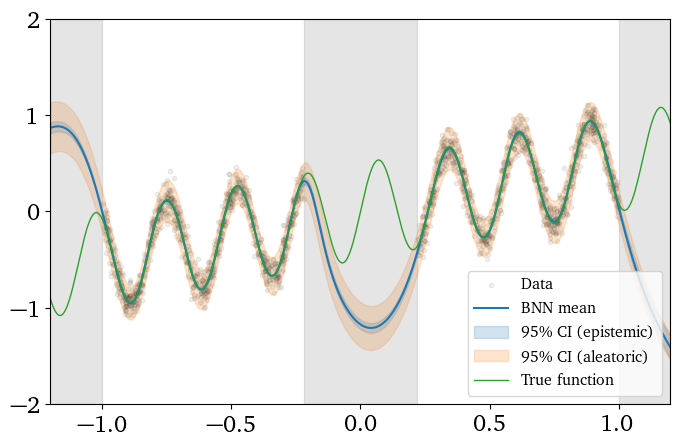

In [6]:
make_error_fig(
    data_train=(x_train, y_train),
    x_values=xx,
    y_mean=mean,
    y_std_epistemic=std,
    y_std_aleatoric=sigmean,
    network_name="BNN",
)